Problem 1: Lasso

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import median_absolute_error

In [109]:
np.random.seed(42)

In [111]:
df = pd.read_csv("C:/Users/palad/OneDrive/Desktop/MLHW6/wine.csv")

In [113]:
X = df.drop(columns='Quality')
y = df['Quality']

X_train = X.iloc[:30]
X_test = X.iloc[30:]

y_train = y.iloc[:30]
y_test = y.iloc[30:]

In [115]:
#pipeline

In [117]:
pipe = Pipeline([
    ('IMPUTE', KNNImputer(weights='distance', copy=False)),
    ('SCALE', MinMaxScaler()),
    ('LASSO', Lasso(random_state=42, max_iter=10000))
])

param_grid = {'LASSO__alpha': np.logspace(-1, 0, 3)}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_median_absolute_error', cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_alpha = grid.best_params_['LASSO__alpha']
lasso_coef = best_model.named_steps['LASSO'].coef_
selected_features = X.columns[lasso_coef != 0].tolist()

In [119]:
selected_features

['Aroma', 'Flavor']

In [121]:
lasso_coef

array([ 0.        ,  2.17998284,  0.        ,  3.20927047, -0.        ])

In [123]:
best_alpha

0.1

In [125]:
y_pred_lasso = best_model.predict(X_test)
eout_lasso = median_absolute_error(y_test, y_pred_lasso)

eout_lasso

0.7654000216739183

In [127]:
# debias
X_train_debiased = X_train[selected_features]
X_test_debiased = X_test[selected_features]

debias_model = LinearRegression()
debias_model.fit(X_train_debiased, y_train)


y_pred_debias = debias_model.predict(X_test_debiased)
eout_debias = median_absolute_error(y_test, y_pred_debias)


debias_coefs = pd.Series(debias_model.coef_, index=selected_features)

(eout_debias, debias_coefs)

(0.8363251214664889,
 Aroma     0.727515
 Flavor    1.000902
 dtype: float64)

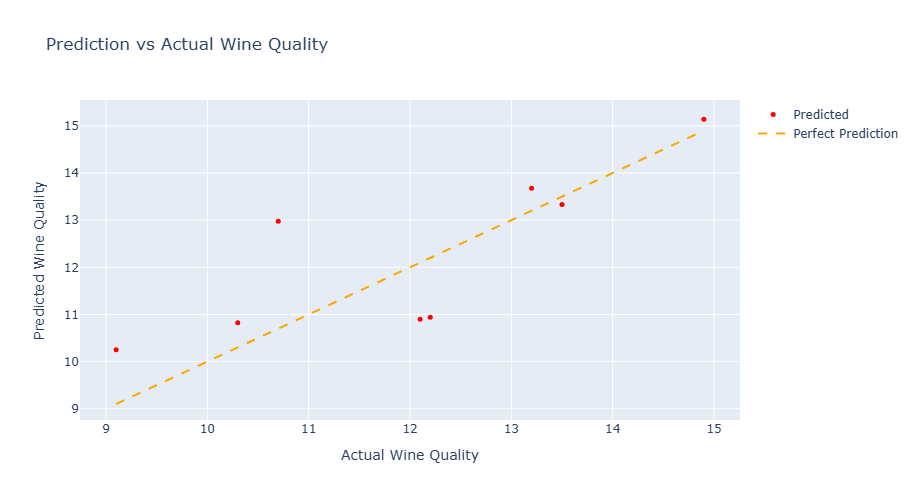

In [193]:
# plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test,
    y=y_pred_debias,
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Predicted'
))

fig.add_trace(go.Scatter(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    mode='lines',
    line=dict(dash='dash', color='orange'),
    name='Perfect Prediction'
))

fig.update_layout(
    title='Prediction vs Actual Wine Quality',
    xaxis_title='Actual Wine Quality',
    yaxis_title='Predicted Wine Quality',
    width=900,
    height=500
)

fig.show()

Problem 2: NN

In [133]:
df = pd.read_csv("C:/Users/palad/OneDrive/Desktop/MLHW6/siCoData.csv")

In [135]:
# Convert to NumPy array
data = df.values

In [137]:
# Separate features and labels
X = data[:, 0].reshape(-1, 1)
y = data[:, 1].reshape(-1, 1)

In [139]:
# Get number of samples
N = X.shape[0]
print(f"Number of samples: {N}")

Number of samples: 250


In [141]:
# Set random seed
np.random.seed(42)

In [143]:
# Set number of hidden units
hidden_units = 10

In [145]:
# Initialize weights and biases
W1 = np.random.randn(1, hidden_units)
b1 = np.zeros((1, hidden_units))

W2 = np.random.randn(hidden_units, 1)
b2 = np.zeros((1, 1))

In [147]:
# Define tanh activation function
def tanh(x):
    return np.tanh(x)

In [149]:
# Derivative of tanh
def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

In [151]:
# Linear activation function
def linear(x):
    return x

In [153]:
# Derivative of linear
def linear_derivative(x):
    return np.ones_like(x)

In [155]:
# Forward pass
def forward_pass(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    a1 = tanh(z1)
    z2 = np.dot(a1, W2) + b2
    y_hat = linear(z2)
    return z1, a1, z2, y_hat

In [157]:
# Mean Squared Error loss
def mse_loss(y, y_hat):
    return np.mean((y - y_hat) ** 2)

In [159]:
# Backward pass
def backward_pass(X, y, z1, a1, z2, y_hat, W2):
    dL_dy_hat = 2 * (y_hat - y) / y.shape[0]
    dL_dW2 = np.dot(a1.T, dL_dy_hat)
    dL_db2 = np.sum(dL_dy_hat, axis=0, keepdims=True)
    dL_da1 = np.dot(dL_dy_hat, W2.T)
    dL_dz1 = dL_da1 * tanh_derivative(z1)
    dL_dW1 = np.dot(X.T, dL_dz1)
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
    return dL_dW1, dL_db1, dL_dW2, dL_db2

In [161]:
# Update weights
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

In [163]:
# Set training parameters
epochs = 1000
learning_rate = 0.01
target_error = 0.01
loss_history = []


In [165]:
# SGD Training loop with stopping criteria
for epoch in range(epochs):
    total_loss = 0
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    for i in indices:
        xi = X[i].reshape(1, -1)
        yi = y[i].reshape(1, -1)
        
        z1, a1, z2, y_hat = forward_pass(xi, W1, b1, W2, b2)
        loss = mse_loss(yi, y_hat)
        total_loss += loss
        
        dW1, db1, dW2, db2 = backward_pass(xi, yi, z1, a1, z2, y_hat, W2)
        W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    avg_loss = total_loss / X.shape[0]
    loss_history.append(avg_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss}")
    
    if avg_loss < target_error:
        print(f"Stopping early at epoch {epoch}, Loss: {avg_loss}")
        break

Epoch 0, Loss: 0.3988464226386581
Epoch 100, Loss: 0.01542140371740258
Epoch 200, Loss: 0.014502386252199581
Epoch 300, Loss: 0.014141332653004641
Epoch 400, Loss: 0.012853952096741178
Epoch 500, Loss: 0.012855316614193825
Epoch 600, Loss: 0.011890527999529358
Epoch 700, Loss: 0.01171644067284918
Epoch 800, Loss: 0.011999408179045606
Epoch 900, Loss: 0.011695615911256254


In [167]:
# Final prediction using trained weights
_, _, _, final_predictions = forward_pass(X, W1, b1, W2, b2)

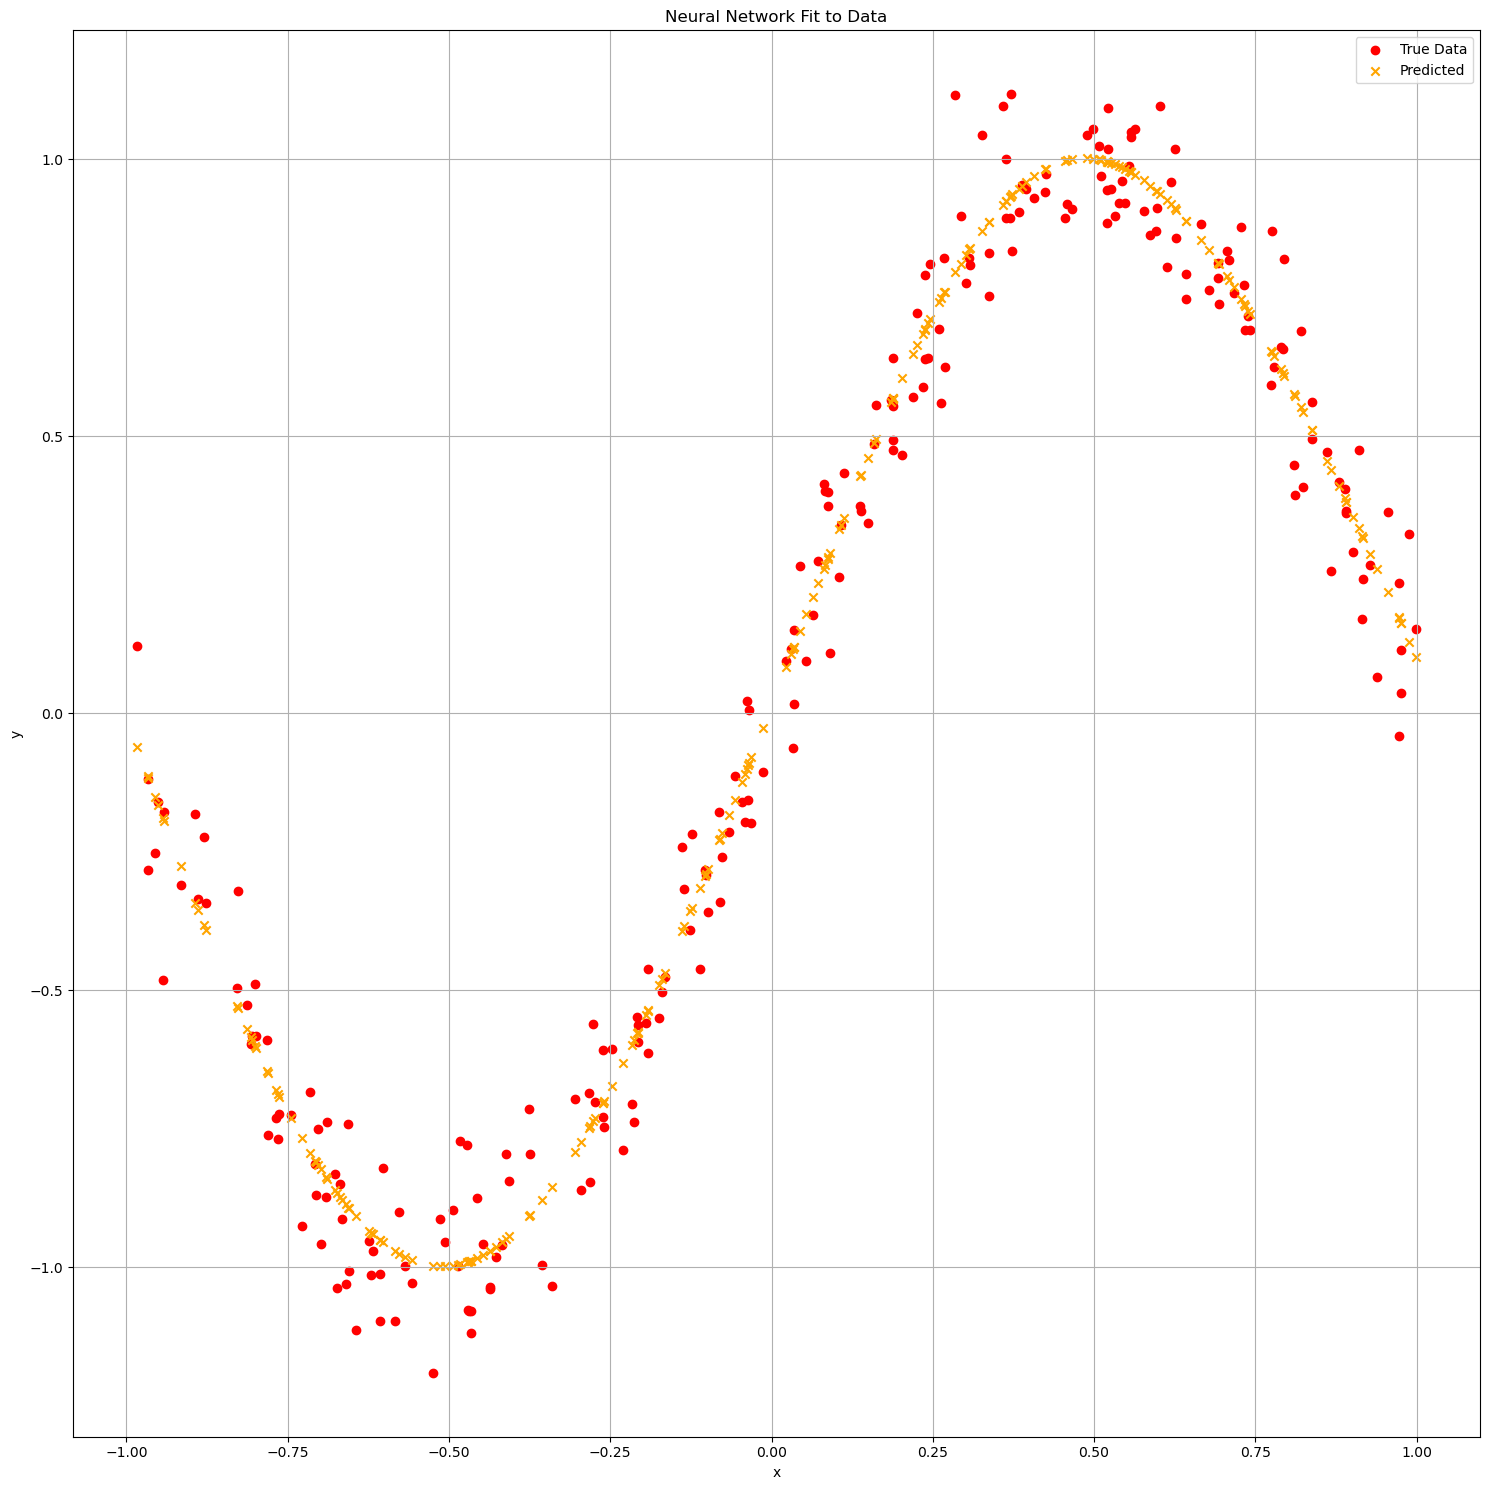

In [199]:
# Plot
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X, y, label="True Data", color="red")
ax.scatter(X, final_predictions, label="Predicted", color="orange", marker='x')
ax.set_title("Neural Network Fit to Data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()